In [1]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.LayerNorm(dim)
        )
        
    def forward(self, x):
        return x + self.block(x)

class VAE(nn.Module):
    def __init__(self, input_dim=187, hidden_dims=[256, 128, 64], latent_dim=25, dropout_rate=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                ResidualBlock(hidden_dim)
            ])
            in_dim = hidden_dim
            
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space projections with additional complexity
        self.fc_mu = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[-1], latent_dim)
        )
        
        self.fc_var = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[-1], latent_dim)
        )
        
        # Decoder
        decoder_layers = []
        hidden_dims = hidden_dims[::-1]  # Reverse for decoder
        in_dim = latent_dim
        
        for hidden_dim in hidden_dims:
            decoder_layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                ResidualBlock(hidden_dim)
            ])
            in_dim = hidden_dim
            
        decoder_layers.append(nn.Linear(hidden_dims[-1], input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
        # 正则化层
        self.input_norm = nn.LayerNorm(input_dim)
        self.latent_norm = nn.LayerNorm(latent_dim)

    def encode(self, x):
        x = self.input_norm(x)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return self.latent_norm(z)  # 对隐变量进行归一化

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var
    
    def generate_from_sample(self, x, num_samples=1, dim_shift=None, shift_range=(-1,1), device='cpu'):
        with torch.no_grad():
            mu, log_var = self.encode(x)
            batch_size = x.shape[0]
            
            all_samples = []
            for i in range(batch_size):
                curr_mu = mu[i:i+1].repeat(num_samples, 1)
                curr_log_var = log_var[i:i+1].repeat(num_samples, 1)
                
                z = self.reparameterize(curr_mu, curr_log_var)
                
                if dim_shift is not None:
                    min_val, max_val = shift_range
                    shifts = torch.linspace(min_val, max_val, num_samples, device=device)
                    z[:,dim_shift] += shifts
                
                samples = self.decode(z)
                all_samples.append(samples.cpu())
                
        return all_samples


In [3]:
class ExtendedVAE(VAE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)  # 继承 VAE 的初始化方法

    def get_latent_z(self, x):
        """
        从输入数据 x 中提取隐变量 z
        :param x: 输入数据，形状为 (batch_size, input_dim)
        :return: 隐变量 z，形状为 (batch_size, latent_dim)
        """
        with torch.no_grad():  # 禁用梯度计算
            mu, log_var = self.encode(x)  # 编码器输出 mu 和 log_var
            z = self.reparameterize(mu, log_var)  # 重参数化得到 z
        return z

In [4]:
import numpy as np
from scipy.fftpack import dct, idct

data = np.load('./data/mitbih_test.npy')
arr = data[:,:-1]
label = data[:,-1]
print(arr.shape)
arr_dct = dct(arr,type = 1, norm='ortho')


(21892, 187)


In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
vae_dct = VAE()
vae_dct.to(device)
device

device(type='cuda', index=1)

In [6]:
train_data, test_data = train_test_split(arr_dct, test_size=0.2, random_state=42)
# 将数据转换为张量
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)
# 创建数据集
train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
import matplotlib.pyplot as plt

loss_fn = nn.MSELoss()
optimizer = optim.Adam(vae_dct.parameters(), lr=1e-4)

train_loss_dct = []
test_loss_dct= []

# 外层循环遍历 epoch
for epoch in range(5):
    epoch_train_loss = 0
    train_batches = 0

    # 内循环使用 tqdm 显示 batch 进度
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}')
    for i, data in progress_bar:
        
        optimizer.zero_grad()
        input_data = data[0].to(device)
        recon, mu, log_var = vae_dct(input_data)
        loss = loss_fn(recon, input_data)
        loss.backward()
        optimizer.step()

        # 更新 tqdm 的 postfix，显示当前 batch 的损失
        progress_bar.set_postfix({'Loss': loss.item()})
        
        if i%10 == 0:
            
            train_loss_dct.append(loss.item())
            with torch.no_grad():
                test_loss_epoch = 0
                test_batches = 0
                for test_batch in test_loader:
                    test_input = test_batch[0].to(device)
                    test_recon, test_mu, test_log_var = vae_dct(test_input)
                    test_loss_val = loss_fn(test_recon, test_input)
                    test_loss_epoch += test_loss_val.item()
                    test_batches += 1
                test_loss_epoch /= test_batches
                test_loss_dct.append(test_loss_epoch)
            


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:23<00:00, 23.28it/s, Loss=0.0187]


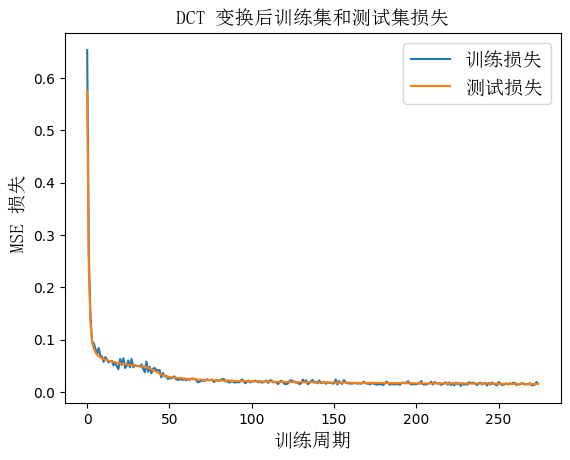

In [10]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font_path = '/usr/share/fonts/simsun/SimSun.ttc'
font = FontProperties(fname=font_path, size=14)

plt.plot(train_loss_dct, label='训练损失')
plt.plot(test_loss_dct, label='测试损失')
plt.legend(prop=font)
plt.xlabel('训练周期', fontproperties=font)
plt.ylabel(' MSE 损失', fontproperties=font)
plt.title('DCT 变换后训练集和测试集损失', fontproperties=font)
plt.savefig('./fig/Training-Test-Loss-dct.pdf')
plt.show()

In [11]:
test_loss_dct[-1]

0.01503046596572347

In [37]:
vae_recon = []

for test_batch in tqdm(test_loader):
    test_input = test_batch[0].to(device)
    test_recon, test_mu, test_log_var = vae_dct(test_input)
    vae_recon.append(test_recon.detach().cpu().numpy())
    
vae_recon = torch.tensor(idct(np.concatenate(vae_recon), type=1, norm='ortho'))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 438.46it/s]


In [38]:
test_arr = torch.tensor(idct(np.array(test_data), type=1, norm='ortho'))

In [39]:
loss_fn(test_arr,vae_recon)

tensor(0.0151)

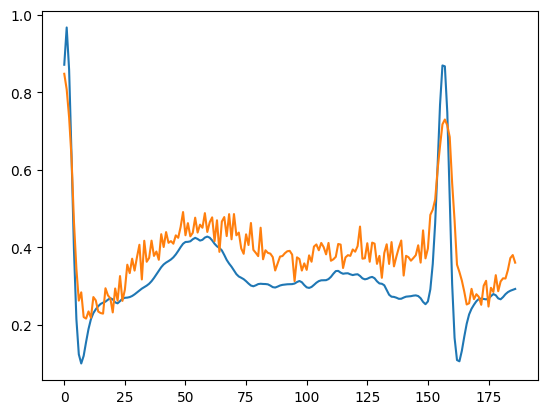

In [57]:
plt.plot(test_arr[0])
plt.plot(vae_recon[0])
plt.show()

In [40]:
vae = VAE()
vae.to(device)
print('ok')

ok


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548/548 [00:23<00:00, 23.53it/s, Loss=0.0165]
/tmp/ipykernel_3171013/3010560696.py:59: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.savefig('./fig/Training-Test-Loss.pdf')
/tmp/ipykernel_3171013/3010560696.py:59: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig('./fig/Training-Test-Loss.pdf')
/tmp/ipykernel_3171013/3010560696.py:59: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig('./fig/Training-Test-Loss.pdf')
/tmp/ipykernel_3171013/3010560696.py:59: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig('./fig/Training-Test-Loss.pdf')
/tmp/ipykernel_3171013/3010560696.py:59: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) miss

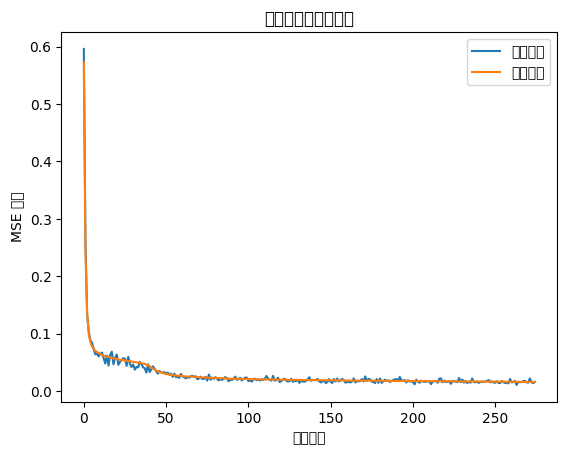

In [41]:
train_data, test_data = train_test_split(arr, test_size=0.2, random_state=42)
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)
# 创建数据集
train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


loss_fn = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

train_loss = []
test_loss = []

# 外层循环遍历 epoch
for epoch in range(5):
    epoch_train_loss = 0
    train_batches = 0

    # 内循环使用 tqdm 显示 batch 进度
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}')
    for i, data in progress_bar:
        
        optimizer.zero_grad()
        input_data = data[0].to(device)
        recon, mu, log_var = vae(input_data)
        loss = loss_fn(recon, input_data)
        loss.backward()
        optimizer.step()

        # 更新 tqdm 的 postfix，显示当前 batch 的损失
        progress_bar.set_postfix({'Loss': loss.item()})
        
        if i%10 == 0:
            
            train_loss.append(loss.item())
            with torch.no_grad():
                test_loss_epoch = 0
                test_batches = 0
                for test_batch in test_loader:
                    test_input = test_batch[0].to(device)
                    test_recon, test_mu, test_log_var = vae(test_input)
                    test_loss_val = loss_fn(test_recon, test_input)
                    test_loss_epoch += test_loss_val.item()
                    test_batches += 1
                test_loss_epoch /= test_batches
                test_loss.append(test_loss_epoch)
            

plt.plot(train_loss, label='训练损失')
plt.plot(test_loss, label='测试损失')
plt.legend()
plt.xlabel('训练进度')
plt.ylabel('MSE 损失')
plt.title('训练集和测试集损失')
plt.savefig('./fig/Training-Test-Loss.pdf')
plt.show()

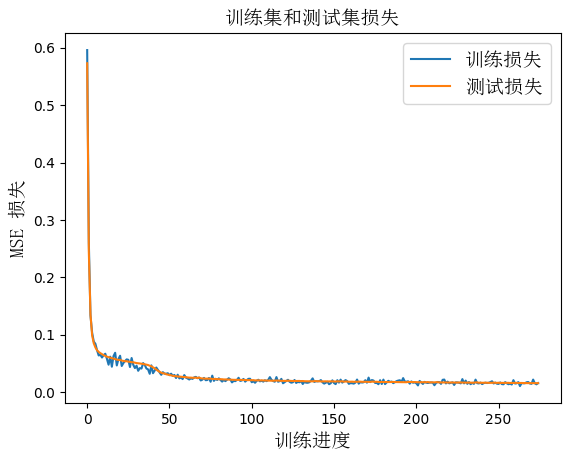

In [43]:
plt.plot(train_loss, label='训练损失')
plt.plot(test_loss, label='测试损失')
plt.legend(prop=font)
plt.xlabel('训练进度', fontproperties=font)
plt.ylabel('MSE 损失', fontproperties=font)
plt.title('训练集和测试集损失', fontproperties=font)
plt.savefig('./fig/Training-Test-Loss.pdf')
plt.show()

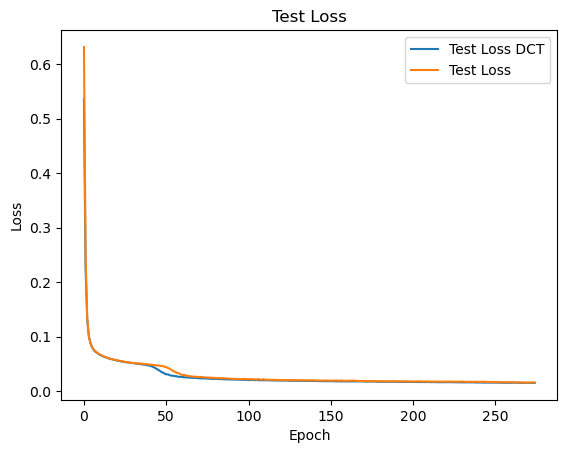

In [16]:
plt.plot(test_loss_dct, label='Test Loss DCT')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.savefig('./fig/Test-Loss-compare.pdf')

plt.show()

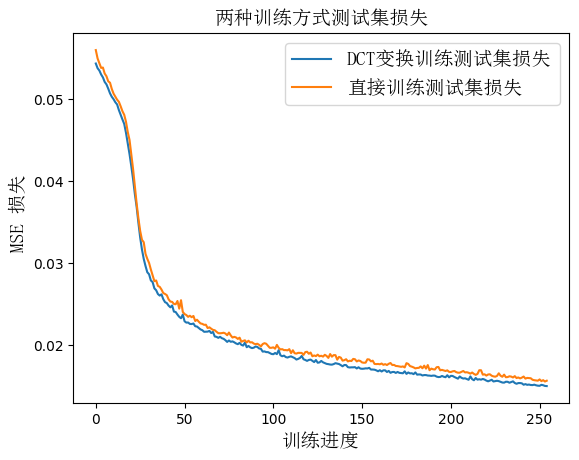

In [45]:
plt.plot(test_loss_dct[20:], label='DCT变换训练测试集损失')
plt.plot(test_loss[20:], label='直接训练测试集损失')
plt.legend(prop=font)
plt.xlabel('训练进度', fontproperties=font)
plt.ylabel(' MSE 损失', fontproperties=font)
plt.title('两种训练方式测试集损失', fontproperties=font)
plt.savefig('./fig/Test-Loss-compare2.pdf')

plt.show()

In [50]:
test_loss[-1],test_loss_dct[-1],(test_loss[-1]-test_loss_dct[-1])/test_loss_dct[-1]

(0.015684799767051734, 0.01503046596572347, 0.043533833403465526)

# 提取隐层表示

In [37]:
plot_data = torch.FloatTensor(arr)
plot_loader = DataLoader(plot_data, batch_size=32, shuffle=False)

In [46]:
    
import numpy as np
import umap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 假设 test_loader 是已经定义好的 DataLoader
# 假设 device 是模型所在的设备（如 'cuda' 或 'cpu'）

# 设置为评估模式
vae.eval()  # 设置为评估模式

# 创建 ExtendedVAE 实例并加载已训练好的参数
extended_vae = ExtendedVAE()
extended_vae.load_state_dict(vae.state_dict())
extended_vae.to(device)  # 将模型移动到设备
extended_vae.eval()

# 提取隐变量 z
z_lst = []
for test_batch in tqdm(plot_loader):
    test_input = test_batch.to(device)  # 将输入数据移动到设备
    z = extended_vae.get_latent_z(test_input).cpu().numpy()  # 提取 z 并转换为 NumPy 数组
    z_lst.append(z)

# 将 z_lst 拼接为一个 NumPy 数组
z_arr = np.concatenate(z_lst, axis=0)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 685/685 [00:00<00:00, 892.72it/s]


In [49]:
# 使用 UMAP 进行降维
umap_reducer = umap.UMAP(n_components=2, random_state=42)  # 降维到 2D
z_umap = umap_reducer.fit_transform(z_arr)


In [50]:
z_umap.shape

(21892, 2)

In [52]:
label_str = np.array([str(i) for i in label])

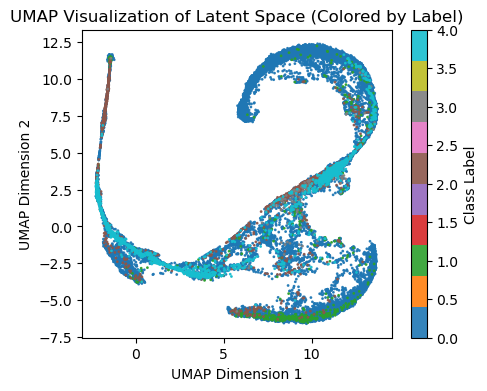

In [105]:
plt.figure(figsize=(5, 4))
scatter = plt.scatter(z_umap[:, 0], z_umap[:, 1], c=label.astype(int), cmap='tab10', s=1, alpha=0.9)
plt.colorbar(scatter, label='Class Label')  # 添加颜色条
plt.title('UMAP Visualization of Latent Space (Colored by Label)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
# plt.grid(True)
plt.savefig('./fig/UMAP.pdf')

plt.show()

In [65]:
# 对z_arr 和 label_str 分别作为 x 和 y 分数据集，并且采用机器学习方式拟合，输出混淆矩阵和 AUC F1-score ACC 等指标

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

label_arr = label.astype(int)  # 如果标签是字符串形式的整数

X_train, X_test, y_train, y_test = train_test_split(z_arr, label_arr, test_size=0.2, random_state=42)


In [107]:
# 训练机器学习模型（以随机森林为例）
model = RandomForestClassifier(random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 用于计算 AUC


F1-score: 0.8398
Accuracy: 0.8678


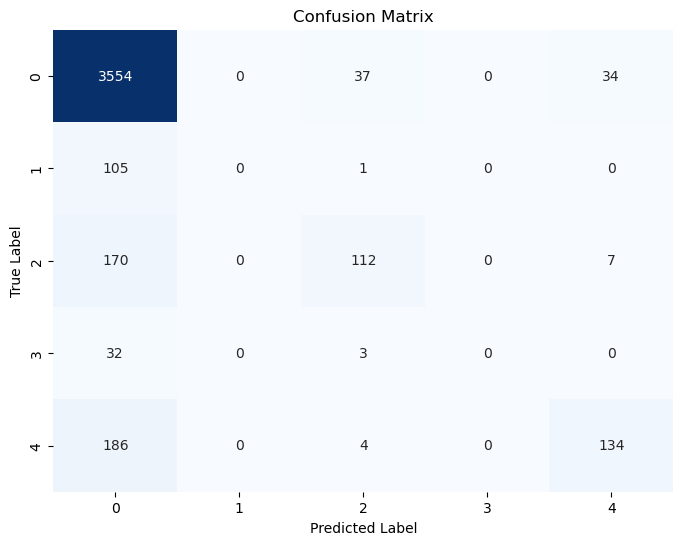

In [108]:
# 计算评估指标
conf_matrix = confusion_matrix(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')  # 多分类 AUC
f1 = f1_score(y_test, y_pred, average='weighted')  # 多分类 F1-score
acc = accuracy_score(y_test, y_pred)

# 输出评估指标
# print(f"AUC: {auc_score:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label_arr), yticklabels=np.unique(label_arr))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('./fig/RandomForestClassifier.pdf')

plt.show()

AUC: 0.8543
F1-score: 0.8503
Accuracy: 0.8712


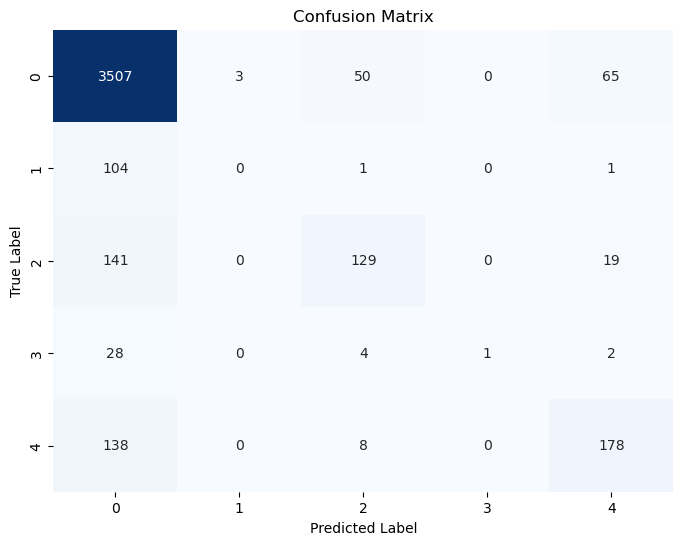

In [109]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score
# from imblearn.over_sampling import SMOTE  # 过采样方法
import seaborn as sns
import matplotlib.pyplot as plt

# 处理标签不均衡：使用 SMOTE 过采样
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = X_train, y_train
# 训练 MLP 模型
model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)#, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # 用于计算 AUC

# 计算评估指标
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')  # 多分类 AUC
f1 = f1_score(y_test, y_pred, average='weighted')  # 多分类 F1-score
acc = accuracy_score(y_test, y_pred)

# 输出评估指标
print(f"AUC: {auc_score:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label_arr), yticklabels=np.unique(label_arr))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('./fig/MLP.pdf')

plt.show()

In [85]:
pip install xgboost

  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [86]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 

In [110]:
model = XGBClassifier(random_state=42, scale_pos_weight=1)  # scale_pos_weight 用于处理类别不均衡
model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 用于计算 AUC


/home/wxz/software/conda_wxz/envs/torch2.0/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:51:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score: 0.8433
Accuracy: 0.8657


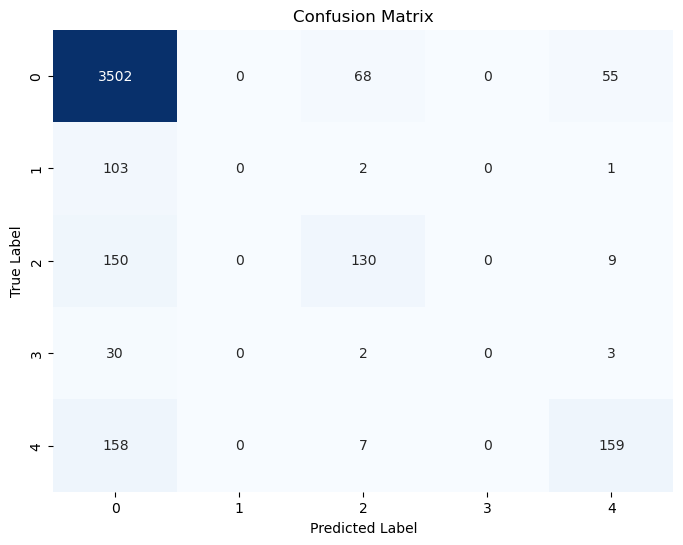

In [111]:
# 计算评估指标
conf_matrix = confusion_matrix(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred_proba,multi_class='ovo')   # AUC
f1 = f1_score(y_test, y_pred, average='weighted')  # 多分类 F1-score
acc = accuracy_score(y_test, y_pred)  # 准确率

# 输出评估指标
# print(f"AUC: {auc_score:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(label_arr), yticklabels=np.unique(label_arr))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('./fig/XGBClassifier.pdf')

plt.show()